In [1]:
%reload_ext google.cloud.bigquery
from datetime import date
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil
from IPython.display import display, HTML
import os

CDR_version=%env WORKSPACE_CDR

### Defining MDD Case Individuals
Case: 
1. Has any instances ever of any diagnostic code for depression, and 
2. Fails to qualify by the 2/30/180 rule for diagnosis of depression with pyschosis, and 
3. Qualifies by the 2/30/180 rule for diagnosis of major depression <br>
2/30/180 = This rule requires evidence to be present on at least two (2) distinct calendar days that are at least thirty (30) days apart and not more than one hundred and eighty (180) days apart.  For example, to qualify as a major depression case (depression type 2), a patient’s record must have at least two instances of diagnosis codes for major depression, and the dates associated with these diagnoses must be at least 30 days but not more than 180 days apart. <br>

In [2]:
all_codes_icd9 = ",".join(["'"+code+"'" for code in ['296.34', '298', "296.2", "296.21", "296.22", "296.23", 
                                                     "296.25", "296.26", "296.3", "296.31", "296.32", 
                                                     "296.33", "296.35", "296.36", "311", "300.4", "309.1"]])
all_codes_icd10 = ",".join(["'"+code+"'" for code in ['F32.3', 'F33.3', "F32.0", "F32.1", "F32.2", "F32.4", 
                                                      "F32.5", "F32.9", "F33.0", "F33.1", "F33.2", "F33.40", 
                                                      "F33.41", "F33.42","F33.9", "F32.89", "F33.8", "F43.21"]])

query = ("""
SELECT distinct * 
FROM 
    (SELECT DISTINCT person_id, condition_source_concept_id, condition_source_value, condition_start_date 
        FROM `"""+CDR_version+""".condition_occurrence`) AS cond 
     INNER JOIN 
        (SELECT DISTINCT concept_id, concept_name, concept_code, vocabulary_id 
            FROM `"""+CDR_version+""".concept` 
            where (concept_code in ("""+all_codes_icd9+""") 
            and vocabulary_id ='ICD9CM') or (concept_code in ("""+all_codes_icd10+""")
            and vocabulary_id ='ICD10CM')) as concept 
            on concept.concept_id = cond.condition_source_concept_id
            INNER JOIN `"""+CDR_version+""".cb_search_person` as is_genotyped
            ON cond.person_id = is_genotyped.person_id
            WHERE is_genotyped.has_whole_genome_variant = 1
            
""")
all_dep_codes = pd.read_gbq(query, dialect="standard")

In [3]:
def _aggregate(x):
        d = {}
        distances =x.condition_start_date.diff()
        d['at_least_30_days_and_no_more_than_180_days'] = np.any((np.abs(distances.dt.days)>=30) & 
                                                                 (np.abs(distances.dt.days)<=180))
        d['Count'] = len(x)
        d['condition_start_date'] = x['condition_start_date'].min()
        return pd.Series(d, index=['at_least_30_days_and_no_more_than_180_days', 'Count', 'condition_start_date'])

# find and then exclude all patients that qualitfy for depression with psychosis by 2/30/180 rule (type 1)
type1_inds = all_dep_codes.loc[all_dep_codes['concept_code'].isin(['296.34', '298',
                                                                  'F32.3', 'F33.3'])]
type1_inds_nodups = type1_inds.drop_duplicates(subset=['person_id', 'condition_start_date', 'concept_code'])
type1_inds_nodups.sort_values(by='condition_start_date', inplace=True)
type1_inds_nodups = type1_inds_nodups.groupby(['person_id'], as_index=False).apply(_aggregate)
type1_final = type1_inds_nodups[(type1_inds_nodups.Count>=2)&
                                (type1_inds_nodups.at_least_30_days_and_no_more_than_180_days)]

dep_cases_notype1 = all_dep_codes.loc[~all_dep_codes['person_id'].isin(type1_final['person_id'])]


In [4]:
# qualifies for MDD by 2/30/180 rule (type 2)
dep_cases_notype1 = dep_cases_notype1.loc[all_dep_codes['concept_code'].isin(["296.2", "296.21", "296.22", "296.23", 
                                                                   "296.25", "296.26","296.3", "296.31", 
                                                                   "296.32", "296.33", "296.35", "296.36",
                                                                   "F32.0", "F32.1", "F32.2", "F32.4", 
                                                                   "F32.5", "F32.9", "F33.0", "F33.1", 
                                                                   "F33.2", "F33.40", "F33.41", "F33.42", 
                                                                   "F33.9"])]
type2_nodups = dep_cases_notype1.drop_duplicates(subset=['person_id', 'condition_start_date', 'concept_code'])
type2_nodups.sort_values(by='condition_start_date', inplace=True)
type2_nodups = type2_nodups.groupby(['person_id'], as_index=False).apply(_aggregate)
type2_final = type2_nodups[(type2_nodups.Count>=2)&(type2_nodups.at_least_30_days_and_no_more_than_180_days)]

In [5]:
cases = type2_final.reset_index()

In [6]:
print("There are", cases.shape[0], "MDD cases identified with the eMERGE algorithm")

There are 23092 MDD cases identified with the eMERGE algorithm


### Extracting Medication Information 

The phenotyping algorithm for medication consideration will have the following criteria: 
1. For medication to be considered, MDD diagnositc code needed to appear before or after 30 days of the medication dispense date


In [7]:
mdd_patients = ",".join(["'"+str(person)+"'" for person in cases.person_id])
query = """
SELECT DISTINCT dr.person_id, 
dr.drug_concept_ID, 
dr.drug_exposure_start_date, 
dr.drug_exposure_id, 
d_standard_concept.concept_name as standard_concept_name
FROM `"""+CDR_version+""".drug_exposure` dr
LEFT JOIN `""" +CDR_version+ """.concept` d_standard_concept 
ON dr.drug_concept_ID = d_standard_concept.concept_id
WHERE cast(dr.person_id as string) in ("""+mdd_patients+""")
AND (d_standard_concept.concept_name LIKE 'citalopram%' OR 
d_standard_concept.concept_name LIKE 'escitalopram%' OR
d_standard_concept.concept_name LIKE 'fluoxetine%' OR
d_standard_concept.concept_name LIKE 'paroxetine%' OR
d_standard_concept.concept_name LIKE 'fluvoxamine%' OR
d_standard_concept.concept_name LIKE 'sertraline%' OR
d_standard_concept.concept_name LIKE 'desvenlafaxine%' OR
d_standard_concept.concept_name LIKE 'duloxetine%' OR
d_standard_concept.concept_name LIKE 'levomilnacipran%' OR
d_standard_concept.concept_name LIKE 'milnacipran%' OR
d_standard_concept.concept_name LIKE 'venlafaxine%' OR
d_standard_concept.concept_name LIKE 'bupropion%' OR
d_standard_concept.concept_name LIKE 'mirtazapine%' OR
d_standard_concept.concept_name LIKE 'nefazodone%' OR
d_standard_concept.concept_name LIKE 'trazodone%' OR
d_standard_concept.concept_name LIKE 'vilazodone%' OR
d_standard_concept.concept_name LIKE 'vortioxetine%' OR
d_standard_concept.concept_name LIKE 'imipramine%' OR
d_standard_concept.concept_name LIKE 'amitriptyline%' OR
d_standard_concept.concept_name LIKE 'amoxapine%' OR
d_standard_concept.concept_name LIKE 'clomipramine%' OR
d_standard_concept.concept_name LIKE 'desipramine%' OR
d_standard_concept.concept_name LIKE 'doxepin%' OR
d_standard_concept.concept_name LIKE 'maprotiline%' OR
d_standard_concept.concept_name LIKE 'nortriptyline%' OR
d_standard_concept.concept_name LIKE 'protriptyline%' OR
d_standard_concept.concept_name LIKE 'trimipramine%' OR
d_standard_concept.concept_name LIKE 'isocarboxazid%' OR
d_standard_concept.concept_name LIKE 'phenelzine%' OR
d_standard_concept.concept_name LIKE 'selegiline%' OR
d_standard_concept.concept_name LIKE 'tranylcypromine%' OR
d_standard_concept.concept_name LIKE 'sulrpide%' OR
d_standard_concept.concept_name LIKE 'aripiprazole%' OR
d_standard_concept.concept_name LIKE 'quetiapine%' OR
d_standard_concept.concept_name LIKE 'olanzapine%' OR
d_standard_concept.concept_name LIKE 'clozapine%' OR
d_standard_concept.concept_name LIKE 'ziprasidone%' OR
d_standard_concept.concept_name LIKE 'risperidone%')
"""

medication = pd.read_gbq(query, 
                         dialect="standard",
                         use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ))

In [8]:
len(medication.person_id.unique())

19370

In [9]:
medication['drug'] = medication.standard_concept_name.apply(lambda x: x.split(' ', 1)[0])

medication['category'] = (np.select([medication['drug'].isin(['citalopram', 'escitalopram', 'fluoxetine', 
                                                              'fluvoxamine', 'paroxetine', 'sertraline']),
                                     medication['drug'].isin(['desvenlafaxine', 'duloxetine', 'levomilnacipran', 
                                                              'milnacipran', 'venlafaxine']),
                                     medication['drug'].isin(['bupropion', 'mirtazapine']),
                                     medication['drug'].isin(['nefazodone', 'trazodone', 'vilazodone', 
                                                              'vortioxetine']),
                                     medication['drug'].isin(['imipramine', 'amitriptyline', 'amoxapine', 
                                                              'clomipramine', 'desipramine', 'doxepin', 
                                                              'maprotiline', 'nortriptyline', 'protriptyline', 
                                                              'trimipramine']),
                                     medication['drug'].isin(['isocarboxazid', 'phenelzine', 
                                                              'selegiline', 'tranylcypromine']),
                                     medication['drug'].isin(['sulrpide', 'aripiprazole', 
                                                              'quetiapine', 'olanzapine', 
                                                              'clozapine', 'ziprasidone', 
                                                              'risperidone'])]
                                    ,['SSRI','SNRI','Atypical','Serotonin','Tricyclic','MAOIs','Antipsychotics']))

### Defining SSRI Switchers for Major depression

SSRI switchers were defined as participants being prescribed an SSRI who then received a prescription for another antidepressant within a 90-day window, from 5-95 days of the initial prescription (a switching event). The following additional criteria were applied:

1. a minimum of 5-day window between prescriptions to avoid capturing overlapping prescriptions of two antidepressants (augmentation) as switches and maximum of 90 days ;

2. the pre-switch SSRI was prescribed ≤ 3 times in total to ensure transient exposure;

3. the pre-switch SSRI was prescribed ≤ 2 times before the switch date, to capture early switchers specifically; and

4. the pre-switch SSRI was prescribed ≤ 2 times after the switch date, to ensure augmentation is not captured, while giving a brief allowance period for cross-tapering.

SSRI non-switchers were defined as patients who did not switch from any SSRIs, and received ≥ 3 prescriptions for an SSRI.

The SSRI index date was defined as the first prescription date for the SSRI in switchers and non-switchers. 

In [10]:
meds_nodups = medication.drop_duplicates(subset=['person_id', 
                                                'drug_exposure_start_date', 
                                                'standard_concept_name'])
meds_nodups = meds_nodups.dropna(subset=['person_id'])

#### Defining SSRI non-switchers

In [11]:
# SSRI non-switchers
# defined as patients who did not switch from any SSRIs
# and received ≥ 3 prescriptions for an SSRI.

only_used_ssris = []
for patient, pt_meds in meds_nodups.groupby('person_id'):
    if set(pt_meds['category'].unique()).issubset({'SSRI'}):
        # Count how many SSRIs this patient has
        ssri_count = (pt_meds['category'] == 'SSRI').sum()
        # Only add patients who have more than 3 SSRIs
        if ssri_count > 3:
            only_used_ssris.append(patient)

In [12]:
len(set(only_used_ssris))

2609

#### Defining SSRI switchers

In [13]:
# remove individuals in the only_used_ssris
possible_cases = meds_nodups[~meds_nodups['person_id'].isin(only_used_ssris)]
# remove individuals who have only 1 instance in their medical history
possible_cases = possible_cases.groupby('person_id').filter(lambda group: len(group) > 1)

In [14]:
# get the patients whose first prescription was an SSRI and not in the only_used_ssris
first_med_is_SSRI = []
for patient, pt_meds in possible_cases.groupby('person_id'):
    sorted_med = pt_meds.sort_values(by=['drug_exposure_start_date']).reset_index()
    if sorted_med['category'].iloc[0] == 'SSRI':
        first_med_is_SSRI.append(patient)

In [15]:
extract_cases = possible_cases[possible_cases.person_id.isin(first_med_is_SSRI)]

In [16]:
len(extract_cases.person_id.unique())

7174

In [17]:
# remove individuals whose first treatment was an augmentation with SSRI
def check_for_augmentation(group):
    first_drug = group.iloc[0]
    second_drug = group.iloc[1]

    # Step 3: Check the date difference (within 5 days) and drug name
    date_diff = (second_drug['drug_exposure_start_date'] - first_drug['drug_exposure_start_date']).days
    same_drug_name = first_drug['category'] == second_drug['category']

    # Step 4: Remove the patient if conditions are met
    if date_diff <= 5 and not same_drug_name:
        return False  # This patient should be excluded
    return True  # Keep the patient

extract_cases = extract_cases.sort_values(by=['person_id', 'drug_exposure_start_date'])
filtered_patients = extract_cases.groupby('person_id').filter(check_for_augmentation)

In [18]:
len(filtered_patients.person_id.unique())

6429

In [19]:
def meet_criteria(subset):
    subset = subset.sort_values(by=['drug_exposure_start_date']).reset_index(drop=True)
    first_category = subset.loc[0, 'category']
    switch_idx = subset[(subset['category'] != first_category)]['drug_exposure_start_date'].index
    
    if switch_idx.empty:
        return False
    
    idx = switch_idx[0]
    diff = (subset.loc[idx, 'drug_exposure_start_date'] - subset.loc[idx-1, 'drug_exposure_start_date']).days

    if not (5 <= diff <= 95):#(diff < 5) or (diff > 95):
        return False
    ssri_count = (subset['drug'] == subset.loc[idx-1, 'drug']).sum()
    if ssri_count > 3:
        return False

    before_switch = subset.iloc[:idx]
    after_switch = subset.iloc[idx:]

    count_before_index = (before_switch['drug'] == subset.loc[idx-1, 'drug']).sum()
    count_after_index = (after_switch['drug'] == subset.loc[idx-1, 'drug']).sum()

    if count_before_index > 2:
        return False
    if count_after_index > 2:
        return False
    # If all conditions are satisfied for the entire history, return True to keep this patient
    return True
ssri_switchers = filtered_patients.groupby('person_id').filter(meet_criteria)


In [20]:
len(ssri_switchers.person_id.unique())

355

### Feature Selection 
1. OMIM and HPO to determine phecodes describing SSRI switching
2. Select highly enriched phecodes in SSRI switching cohort as compared to non-SSRI switching and then rank phecodes by p-value to select top K phecodes 
3. Phecodes related to symptoms of SSRI switching i.e. mood disorder, suicidal ideation, alcohol use disorder, substance use disorder, eating disorder, anxiety, etc.
4. Polygenic Risk Score for MDD
5. age, sex, smoking, first 10 PCs

In [21]:
demographic_sql = """
    SELECT
        person.person_id as ID,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as birth_date,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as self_identified_sex 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id
    WHERE person.PERSON_ID IN (
    SELECT distinct cb_search_person.person_id  
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
        WHERE cb_search_person.has_whole_genome_variant = 1 )"""

demographic_df = pd.read_gbq(
    demographic_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

demographic_df.head(5)

Downloading:   0%|          | 0/245388 [00:00<?, ?rows/s]

,ID,gender_concept_id,gender,birth_date,race_concept_id,race,ethnicity_concept_id,ethnicity,sex_at_birth_concept_id,self_identified_sex
0,1036100,1585843,Gender Identity: Additional Options,1996-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,4124462,None
1,1938775,1585843,Gender Identity: Additional Options,1986-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,4124462,None
2,3028890,1585843,Gender Identity: Additional Options,1982-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,4124462,None
3,2061175,1177221,I prefer not to answer,1997-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,4124462,None
4,9251240,1177221,I prefer not to answer,1979-06-15 00:00:00+00:00,1177221,I prefer not to answer,903079,PMI: Prefer Not To Answer,4124462,None


In [22]:
cohort = demographic_df[demographic_df.ID.isin(ssri_switchers.person_id.unique().tolist() + only_used_ssris)]

In [23]:
cohort['MDD'] = np.where(cohort.ID.isin(ssri_switchers.person_id.unique()), 1, 0)

/tmp/ipykernel_181/788634238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort['MDD'] = np.where(cohort.ID.isin(ssri_switchers.person_id.unique()), 1, 0)


In [24]:
from datetime import datetime, timezone
now = datetime.now(timezone.utc)
cohort['age'] = (now - pd.to_datetime(cohort['birth_date'])).dt.days/365.25

/tmp/ipykernel_181/1600989509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort['age'] = (now - pd.to_datetime(cohort['birth_date'])).dt.days/365.25


In [25]:
cohort = cohort[cohort['self_identified_sex'].isin(['Female', 'Male'])]

In [26]:
# case_cohort = demographic_df
# case_cohort['MDD'] = np.where(case_cohort.ID.isin(cases.person_id), 1, 0)
# case_cohort['age'] = (now - pd.to_datetime(case_cohort['birth_date'])).dt.days/365.25
# case_cohort = case_cohort[case_cohort['self_identified_sex'].isin(['Female', 'Male'])]

In [27]:
orig_df = cohort[['ID','MDD','age', 'self_identified_sex']]
orig_df.columns = ['ID','MDD','n_age', 'n_self_identified_sex']

In [28]:
#ssri_switchers_cases = orig_df[orig_df.MDD == 1]
ids = ",".join(["'"+str(person)+"'" for person in orig_df.ID])
query = ("""
SELECT distinct * 
FROM 
    (SELECT DISTINCT person_id, condition_source_concept_id, condition_source_value, condition_start_date 
        FROM `"""+CDR_version+""".condition_occurrence`) AS cond 
     INNER JOIN 
        (SELECT DISTINCT concept_id, concept_name, concept_code, vocabulary_id 
            FROM `"""+CDR_version+""".concept` 
            where (vocabulary_id ='ICD9CM') or (vocabulary_id ='ICD10CM')) as concept 
            on concept.concept_id = cond.condition_source_concept_id
            WHERE cast(cond.person_id as string) in ("""+ids+""")
            
""")
all_icd_codes = pd.read_gbq(query, dialect="standard")

In [29]:
all_icd_codes = all_icd_codes[['person_id', 'concept_code', 'vocabulary_id']]
all_icd_codes.columns = ['person_id', 'icd_codes', 'vocabulary_id']

In [30]:
# os.system(f'gsutil -m cp gs://fc-secure-60a6c77d-e955-44c3-a038-2de1e1970ffd/phecode_map_icd9_10.csv ' + 'phecode_map_icd9_10.csv')
# os.system(f'gsutil -m cp gs://fc-secure-60a6c77d-e955-44c3-a038-2de1e1970ffd/pheinfo.csv ' + 'pheinfo.csv')
def get_phecodes(df):
    #Load in Files
    ICD9_IC10_Phecodes=pd.read_csv("phecode_map_icd9_10.csv") 
    ICD9_IC10_Phecodes = ICD9_IC10_Phecodes.iloc[:, 1:] # strip off extra column
    phecode_info=pd.read_csv("pheinfo.csv")
    
    ######### map ICD9 and ICD10 to phecodes #########
    icd9_phecode_dict=ICD9_IC10_Phecodes[ICD9_IC10_Phecodes['vocabulary_id']=='ICD9CM']
    icd9_phecode = df.icd_codes.map(dict(zip(icd9_phecode_dict.code,
                                                                 icd9_phecode_dict.phecode)))
    df['ICD9_PHECODE'] = icd9_phecode.astype(float)

    icd10_phecode_dict = ICD9_IC10_Phecodes[ICD9_IC10_Phecodes['vocabulary_id']=='ICD10CM'].reset_index(drop=True)
    icd10_phecode = df.icd_codes.map(dict(zip(icd10_phecode_dict.code,
                                                                 icd10_phecode_dict.phecode)))
    df['ICD10_PHECODE'] = icd10_phecode.astype(float)
    
    ########## drop rows with NA for both IC9_PHECODE and ICD10_PHECODE #########
    df = df.loc[df['ICD9_PHECODE'].notnull() | df['ICD10_PHECODE'].notnull()]

    # select rows into new dfs, based on ICD9- and ICD10-derived phecodes, and append appropriate phecode into 'PHECODE' column

    # for entries with no ICD9-derived phecode, choose 'ICD10_PHECODE' [CONDITION 1]
    null9_df = df.loc[df['ICD9_PHECODE'].isnull()]
    null9_df['PHECODE'] = null9_df['ICD10_PHECODE']

    # for entries with no ICD10-derived phecode, choose 'ICD9_PHECODE' [CONDITION 2]
    null10_df = df.loc[df['ICD10_PHECODE'].isnull()]
    null10_df['PHECODE'] = null10_df['ICD9_PHECODE']
    
    ########### entries with both ICD9- and ICD10-derived phecodes (will get further subdivided) ##########
    icd_df_both_phecodes = df.loc[df['ICD9_PHECODE'].notnull() & df['ICD10_PHECODE'].notnull()]

    # for entries with ICD9- and ICD10-derived phecodes that match, choose 'ICD9_PHECODE' [CONDITION 3]
    icd_df_matched_phecodes = icd_df_both_phecodes[icd_df_both_phecodes['ICD9_PHECODE'] == icd_df_both_phecodes['ICD10_PHECODE']]
    icd_df_matched_phecodes['PHECODE'] = icd_df_matched_phecodes['ICD9_PHECODE']

    # for entries with ICD9- and ICD10-derived phecodes that don't match, duplicate entry and choose one phecode each [CONDITION 4, a and b]
    icd_df_mismatched_phecodes = icd_df_both_phecodes[icd_df_both_phecodes['ICD9_PHECODE'] != icd_df_both_phecodes['ICD10_PHECODE']]
    icd_df_mismatch2 = icd_df_mismatched_phecodes.copy()
    icd_df_mismatched_phecodes['PHECODE'] = icd_df_mismatched_phecodes['ICD9_PHECODE']
    icd_df_mismatch2['PHECODE'] = icd_df_mismatch2['ICD10_PHECODE']

    # combine dfs with phecodes from all 4 conditions
    frames = [null9_df, null10_df, icd_df_matched_phecodes, icd_df_mismatched_phecodes, icd_df_mismatch2]
    icd_df = pd.concat(frames)
    
    #map to the descriptors
    final_phecode_file = pd.merge(icd_df, phecode_info, left_on = 'PHECODE', right_on = 'phecode', how = 'left')
    return final_phecode_file

In [31]:
all_phecodes = get_phecodes(all_icd_codes)

/tmp/ipykernel_181/2127813669.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null9_df['PHECODE'] = null9_df['ICD10_PHECODE']
/tmp/ipykernel_181/2127813669.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null10_df['PHECODE'] = null10_df['ICD9_PHECODE']


In [32]:
case_indiv = orig_df[orig_df['MDD'] == 1]
control_indiv = orig_df[orig_df['MDD'] == 0]

phecodes_cases = all_phecodes[all_phecodes['person_id'].isin(case_indiv.ID)]
phecodes_controls = all_phecodes[all_phecodes['person_id'].isin(control_indiv.ID)]

In [33]:
phecodes_cases = phecodes_cases[['person_id', 'phecode']]
phecodes_cases.columns = ['ID', 'phecode']
print("Number of phecodes in cases", len(phecodes_cases.phecode.unique()))

dummies = pd.get_dummies(phecodes_cases['phecode'])
encoded = pd.concat([phecodes_cases['ID'], dummies], axis=1)
phecode_cases_final = encoded.groupby('ID').sum().astype(int)
phecode_cases_final = phecode_cases_final.reset_index()
phecode_cases_final = phecode_cases_final.apply(pd.to_numeric)

Number of phecodes in cases 1454


In [34]:
phecodes_controls = phecodes_controls[['person_id', 'phecode']]
phecodes_controls.columns = ['ID', 'phecode']

# Convert 'phecode' to a categorical type to save memory
phecodes_controls['phecode'] = phecodes_controls['phecode'].astype('category')

# Create dummies in a memory-efficient way using SparseDataFrame to save memory
dummies = pd.get_dummies(phecodes_controls['phecode'], sparse=True)

# Merge 'ID' with the dummies dataframe
encoded = pd.concat([phecodes_controls['ID'], dummies], axis=1)

# Group by 'ID' and sum the dummy variables, then reset the index
phecode_controls_final = encoded.groupby('ID').sum()

# Convert the dataframe back to integers
phecode_controls_final = phecode_controls_final.astype(int)

# Optional: Convert the entire dataframe to numeric types, in case there are other columns with mixed types
phecode_controls_final = phecode_controls_final.apply(pd.to_numeric)

# If you want to reset the index after grouping
phecode_controls_final = phecode_controls_final.reset_index()

print("Number of phecodes in controls:", len(phecodes_controls['phecode'].unique()))

Number of phecodes in controls: 1678


In [36]:
# phecodes_controls = phecodes_controls[['person_id', 'phecode']]
# phecodes_controls.columns = ['ID', 'phecode']
# print("Number of phecodes in controls", len(phecodes_controls.phecode.unique()))

# dummies = pd.get_dummies(phecodes_controls['phecode'])
# encoded = pd.concat([phecodes_controls['ID'], dummies], axis=1)
# phecode_controls_final = encoded.groupby('ID').sum().astype(int)
# phecode_controls_final = phecode_controls_final.reset_index()
# phecode_controls_final = phecode_controls_final.apply(pd.to_numeric)

In [37]:
missing_cols = [col for col in phecode_controls_final.columns if col not in phecode_cases_final.columns]

# Add the missing columns to the cases dataframe with all zeros
for col in missing_cols:
    phecode_cases_final[col] = 0

# Now both cases_df and controls_df have the same columns
# Concatenate the two dataframes (you can concatenate along rows, i.e., axis=0)
phecode_final = pd.concat([phecode_cases_final, phecode_controls_final], axis=0, ignore_index=True)

# Now combined_df has all the categories for both cases and controls
#print(phecode_final.head())

In [38]:
# all_phecodes = all_phecodes[['person_id', 'phecode']]
# all_phecodes.columns = ['ID', 'phecode']
# print("Number of phecodes", len(all_phecodes.phecode.unique()))

# dummies = pd.get_dummies(all_phecodes['phecode'])
# encoded = pd.concat([all_phecodes['ID'], dummies], axis=1)
# phecode_final = encoded.groupby('ID').sum().astype(int)
# phecode_final = phecode_final.reset_index()
# phecode_final = phecode_final.apply(pd.to_numeric)

In [39]:
orig_df = pd.merge(orig_df, phecode_final, on = 'ID')

In [40]:
print("Shape of patient features matrix: (%d, %d)" % (orig_df.shape[0], orig_df.shape[1]))

Shape of patient features matrix: (2919, 1691)


In [41]:
cat_features = [str(col) for col in orig_df.columns if str(col).startswith('n_')]
print("Non-phecode features in feature matrix: ")
print(cat_features)

target_label = 'MDD'
patient_label = 'ID'

non_phecode_features = cat_features + [target_label, patient_label]
non_phecode_df = orig_df[non_phecode_features]
orig_df.drop(non_phecode_features, axis=1, inplace=True)
orig_df.columns = orig_df.columns.astype(float)
orig_df = pd.concat([orig_df, non_phecode_df], axis=1)

Non-phecode features in feature matrix: 
['n_age', 'n_self_identified_sex']


In [42]:
# read in bridge files 

phecode_icd9_df = pd.read_csv("./phecode_icd9_rolled.csv", sep=',')
phecode_icd10_df = pd.read_csv("./icd10_phecode_bridge.csv", sep=',')
hpo_phecode_df = pd.read_csv("./HPO_phecode_bridge.csv", sep=',')
omim_hpo_df = pd.read_csv("./omim_hpo_bridge.csv", sep=',')

In [43]:
def clean_phecode_files(phecode_icd9_df, phecode_icd10_df):
    phecode_icd10_df.columns = ['ICD10', 'PheCode']
    phecode_df = phecode_icd10_df.merge(phecode_icd9_df, on='PheCode', how='right')
    phecode_df = phecode_df[['ICD10', 'ICD9','PheCode', 'Phenotype', 'Excl. Phecodes']]
    phecode_df.columns = ['ICD10', 'ICD9','Phecode', 'Phenotype', 'Excl. Phecodes']
    phecode_icd_10_df = phecode_df.drop('ICD9', axis=1).drop_duplicates()
    phecode_icd_10_df.columns = ['ICD','Phecode', 'Phenotype', 'Excl. Phecodes']
    phecode_icd_9_df = phecode_df.drop('ICD10', axis=1).drop_duplicates()
    phecode_icd_9_df.columns = ['ICD','Phecode', 'Phenotype', 'Excl. Phecodes']
    phecode_df = pd.concat([phecode_icd_9_df, phecode_icd_10_df]).sort_values(by='Phecode')
    return phecode_df

phecode_df = clean_phecode_files(phecode_icd9_df, phecode_icd10_df)

In [44]:
hpo_phecode_df = hpo_phecode_df[hpo_phecode_df["phecode"].notnull()]
omim_hpo_df.columns = ["DB", "DB_Object_ID","DB_Name", "Qualifer", "HPO_ID", "DB_Reference", 
                       "Evidence", "Onset", "Frequency", "Sex", "Modifier", "Aspect", "Date_Created", 
                       "Assigned_By"]

In [45]:
hpo_phecode_df

,HPO_term_id,HPO_term_name,phecode,phecode_string,class,Unnamed: 5,Unnamed: 6
0,3,Multicystic kidney dysplasia,586.20,"Cyst of kidney, acquired",NaN,NaN,NaN
2,10,Recurrent urinary tract infections,591.00,Urinary tract infection,NaN,NaN,NaN
3,11,Neurogenic bladder,596.50,Functional disorders of bladder,NaN,NaN,NaN
4,12,Urinary urgency,599.90,Other abnormality of urination,NaN,NaN,NaN
5,13,Hypoplasia of the uterus,751.11,Congenital anomalies of female genital organs,Congenital,NaN,NaN
...,...,...,...,...,...,...,...
5748,200133,Lumbosacral meningocele,752.11,Spina bifida,Congenital,NaN,NaN
5749,200134,Epileptic encephalopathy,345.11,Generalized convulsive epilepsy,NaN,NaN,NaN
5750,200138,Bilateral choanal atresia/stenosis,749.00,Congenital anomalies of face and neck,Congenital,NaN,NaN
5751,200141,"Small, conical teeth",520.20,Disturbances in tooth eruption,NaN,NaN,NaN


In [46]:
def hpo_to_phecode_list(hpo_id_list, hpo_phecode_df):
    phecodes = []
    for hpo_id in hpo_id_list:
        phecode = hpo_phecode_df.loc[hpo_phecode_df["HPO_term_id"] == hpo_id]['phecode'].values
    
        if len(phecode) == 0 :
            phecode = [np.nan]

        elif len(phecode) > 1:
            print("WARNING: hpo id mapping to more than one phecode...taking only first phecode in database")

        phecode = phecode[0]
        phecodes.append(phecode)
        
    phecodes = [x for x in phecodes if ~np.isnan(x)]

    return phecodes 

def get_disease_phecodes(disease, omim_hpo_df, hpo_phecode_df):
    hpo_ids = retrieve_hpo_ids(disease, omim_hpo_df, DB="OMIM")
    #print("HPO ids:")
    #print(hpo_ids)
    disease_phecodes = hpo_to_phecode_list(hpo_ids, hpo_phecode_df)

    return disease_phecodes, hpo_ids

def retrieve_hpo_ids(disease, omim_hpo_df, DB="OMIM"):
    # omim database disease field in all caps 
    #disease = disease.upper()
    print("Disease name being read: %s" % disease)
    hpo_id_list = omim_hpo_df.loc[(omim_hpo_df['DB'] == DB) & (omim_hpo_df['DB_Object_ID']==disease)]['HPO_ID'].values
    
    # remove "HP:" prefix
    hpo_id_list = [int(x.split(':')[1]) for x in hpo_id_list]
    
    return hpo_id_list

In [47]:
def get_omim_phecodes(omim_disease_list, hpo_add, hpo_remove, hpo_phecode_df, omim_hpo_df):
        omim_phecodes = []

        # get phecodes to add from hpo terms
        if len(hpo_add) > 1:
            print("Adding phecodes from %d hpo terms" % len(hpo_add))
            phecode_add_hpo = hpo_to_phecode_list(hpo_add, hpo_phecode_df)
            phecode_add = set(phecode_add + phecode_add_hpo)

        # get phecodes to remove from hpo terms 
        if len(hpo_remove) > 1:
            print("Removing phecodes from %d hpo terms" % len(hpo_remove))
            phecode_remove_hpo = hpo_to_phecode_list(hpo_remove, hpo_phecode_df)
            phecode_remove = set(phecode_remove + phecode_remove_hpo)
            
        # get main set of phecodes from omim defn 
        for disease_omim in omim_disease_list:
            omim_phecodes_i, hpo_ids_i = get_disease_phecodes(disease_omim, omim_hpo_df, hpo_phecode_df)
            omim_phecodes.extend(omim_phecodes_i)
        
        print("Originally selecting %d phecodes based on OMIM defn" % len(np.unique(omim_phecodes)))

        # remove any duplicate phecodes
        omim_phecodes = np.unique(omim_phecodes)
            
        n_omim_phecodes = len(omim_phecodes)

        print("Number of OMIM and filtered phecodes: %d" % n_omim_phecodes)
        
        return omim_phecodes

In [48]:
omim_disease_list = [608516, 608691, 608520, 125480, 309200, 611247, 611536, 609633, 612357, 612372,
                    611535, 612371]
hpo_add = []
hpo_remove = []
omim_phecodes = get_omim_phecodes(omim_disease_list, hpo_add, hpo_remove, hpo_phecode_df, omim_hpo_df)

Disease name being read: 608516
Disease name being read: 608691
Disease name being read: 608520
Disease name being read: 125480
Disease name being read: 309200
Disease name being read: 611247
Disease name being read: 611536
Disease name being read: 609633
Disease name being read: 612357
Disease name being read: 612372
Disease name being read: 611535
Disease name being read: 612371
Originally selecting 2 phecodes based on OMIM defn
Number of OMIM and filtered phecodes: 2


In [49]:
omim_phecodes

array([296.1, 296.2])

In [50]:
#split data into training and testing set 
from sklearn.model_selection import train_test_split
train_df = orig_df.copy()
test_df = orig_df.copy()
print("Number of patients in training set: %d" % train_df.shape[0])
print("Number of patients in test set: %d" % test_df.shape[0])

Number of patients in training set: 2919
Number of patients in test set: 2919


In [51]:
def freq_pvalue(p1, p2, n1, n2):
    
    p = (p1 * n1 + p2 * n2)/ float(n1 + n2)
    se = np.sqrt(p*(1-p) * (1/float(n1) + (1/float(n2))))
    z = (p1-p2)/float(se)
    pvalue=2*norm.cdf(-1*abs(z))
    
    return pvalue 

In [52]:
from scipy.stats import norm

In [53]:
def sign_phecodes(train_df, non_phecode_features, omim_phecodes, target_label, target_phecode):  
    phecode_train_df = train_df.drop(non_phecode_features, axis=1)
    phecode_sums=phecode_train_df.sum(axis=0).values
    n_pats = len(train_df.index) # total number of patients 
    all_phecode_freqs=np.divide(phecode_sums, n_pats)

    mdd_phecode_df = train_df.loc[train_df['MDD']==1].drop(non_phecode_features, axis=1)
    mdd_phecode_sums=mdd_phecode_df.sum(axis=0).values
    n_mdd_pats = len(mdd_phecode_df)
    mdd_phecode_freqs=np.divide(mdd_phecode_sums, n_mdd_pats)
    print("Number of cases in training set: %d" % n_mdd_pats)
    
    training_phecodes = phecode_train_df.columns.astype(float)
    freq_df = pd.DataFrame({'Phecode': training_phecodes, 'p1': mdd_phecode_freqs, 'p2': all_phecode_freqs})

    n1 = n_mdd_pats
    n2 = n_pats # general population

    pvalue_list = []

    for p in training_phecodes:
        p1 = freq_df.loc[freq_df['Phecode'] == p, 'p1'].values[0]
        p2 = freq_df.loc[freq_df['Phecode'] == p, 'p2'].values[0]
        pvalue = freq_pvalue(p1, p2, n1, n2)
        pvalue_list.append(pvalue)

    freq_df['pvalue'] = pvalue_list
    freq_df.sort_values(by='pvalue', inplace=True)

    # make sure phecodes are floats 
    freq_df['Phecode'] = freq_df["Phecode"].astype(float)

    # remove CVID phecode
    print("Removing disease target phecode from list.")
    freq_df = freq_df.loc[freq_df['Phecode'] != target_phecode]

    # compute log10 weights from general population
    inv_freq = np.divide(1, freq_df['p2'].values)
    freq_df['weight'] = np.log10(inv_freq)

    # replace inf weight with 0
    print("Replacing inf frequencies with 0.")
    freq_df['weight']=freq_df['weight'].replace([np.inf], 0)
    freq_df['weight']=freq_df['weight'].replace([-1*np.inf], 0)
    freq_df['weight'].fillna(0, inplace=True)

    # drop NAs
    print("Fill NA weights.")
    top_df = freq_df.fillna(0)

    # save freq for later 
    print("Phecode freq df from all phecodes.")
    all_top_df = top_df.copy()

    # dataframe for omim and no-omim
    omim_top_df = all_top_df.copy()

    # drop phecodes with < 2 MDD pats 
    print("Droping phecodes with <2 target patients.")
    mdd_thresh = 2/float(n_mdd_pats)
    omim_top_df = omim_top_df.loc[(omim_top_df['p1'] >= mdd_thresh) | (omim_top_df['Phecode'].isin(omim_phecodes))]
    all_top_df = all_top_df.loc[all_top_df['p1'] >= mdd_thresh]

    # omim df 
    n_phecodes = len(omim_top_df.index)
    thresh = 0.05
    bon_thresh = thresh/n_phecodes
    omim_top_df = omim_top_df.loc[(omim_top_df['pvalue'] <= bon_thresh) | (omim_top_df['Phecode'].isin(omim_phecodes))]
    n_sign_phecodes = len(omim_top_df.index)
    print("Number of significant phecodes after corrections (including OMIM phecodes): %d" % n_sign_phecodes)

    # no-omim df 
    n_phecodes = len(all_top_df.index)
    thresh = 0.05
    bon_thresh = thresh/n_phecodes
    all_top_df = all_top_df.loc[all_top_df['pvalue'] <= bon_thresh]
    print("Restricting to significant phecodes with pvalue <= %.4g (mult testing thresh based on %d phecodes)" % (bon_thresh, n_phecodes))

    # only sign phecodes (regardless of OMIM)
    sign_top_df = all_top_df
    n_sign_phecodes = len(sign_top_df.index)
    print("Number of significant phecodes after corrections (regardless of OMIM): %d" % n_sign_phecodes)

    # make sign phecodes with omim phecodes and sign phecodes
    sign_omim_top_df = omim_top_df.loc[~omim_top_df['Phecode'].isin(omim_phecodes)]
    n_sign_phecodes = len(sign_omim_top_df.index)

    print("Number of significant phecodes after corrections (not including OMIM phecodes): %d" % n_sign_phecodes)

    return sign_top_df, sign_omim_top_df, all_top_df, freq_df

In [54]:
target_phecode = 296.22 # MDD
target_label = 'MDD'
no_omim_phecode_df, omim_phecode_df, all_top_df, freq_df = sign_phecodes(train_df,
                                                                         non_phecode_features,
                                                                         omim_phecodes,
                                                                         target_label, target_phecode)

Number of cases in training set: 349


/tmp/ipykernel_181/2312772194.py:4: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(p*(1-p) * (1/float(n1) + (1/float(n2))))


Removing disease target phecode from list.
Replacing inf frequencies with 0.
Fill NA weights.
Phecode freq df from all phecodes.
Droping phecodes with <2 target patients.
Number of significant phecodes after corrections (including OMIM phecodes): 773
Restricting to significant phecodes with pvalue <= 3.731e-05 (mult testing thresh based on 1340 phecodes)
Number of significant phecodes after corrections (regardless of OMIM): 773
Number of significant phecodes after corrections (not including OMIM phecodes): 771


In [55]:
top_phenotype_df = all_top_df.merge(phecode_df[["Phecode", "Phenotype"]], on='Phecode')
top_phenotype_df.drop_duplicates(inplace=True)

In [56]:
top_phecode_df = omim_phecode_df
target_phecodes = list(omim_phecodes) 
omim = 'omim'

In [57]:
# get top 15 features 
n_features = 15
target_phecodes = target_phecodes + list(top_phecode_df['Phecode'].head(n_features).values)
feature_set = list(target_phecodes)

In [58]:
feature_set

[296.1,
 296.2,
 318.0,
 351.0,
 355.1,
 278.11,
 276.14,
 174.11,
 272.11,
 512.9,
 512.8,
 512.7,
 261.4,
 386.9,
 695.42,
 789.0,
 496.0]

### Random Forest Model 
Cases are MDD individuals identified as being SSRI switchers. Controls are MDD individuals not identified as SSRI switchers

In [59]:
final_df = orig_df[feature_set + ["n_age", "n_self_identified_sex", "MDD"]]
final_encoded = pd.get_dummies(final_df, columns=['n_self_identified_sex'], drop_first=False).astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(final_encoded[feature_set + ["n_age", 
                                                                                 "n_self_identified_sex_Female",
                                                                                 "n_self_identified_sex_Male"]],
                                                    final_encoded['MDD'],
                                                    test_size=0.2, random_state=0)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [60]:
final_encoded.MDD.value_counts()

MDD
0    2570
1     349
Name: count, dtype: int64

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

cv_params = {'n_estimators': [1000, 2000, 2500], 
 'max_depth': [10, 100],
 'min_samples_split': [1, 5],
 'min_samples_leaf': [1, 5],
 'max_features': ['sqrt']}
  
rf = RandomForestClassifier(oob_score=True, random_state=42)
clf = RandomizedSearchCV(estimator=rf, param_distributions=cv_params,
                         cv=5, n_iter=10)

# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, Y_train)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
risk_scores =clf.predict_proba(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_

In [102]:
# y_pred = clf.predict(X_test)

In [96]:
# scores = risk_scores[:,1]
# score_df = pd.DataFrame({'MDD': Y_test.values, 
#                          'Scores': scores})
            

In [97]:
# sorted_results_df = score_df.sort_values(by='Scores', ascending=False)

In [98]:
# total_pats = sorted_results_df.shape[0]
# total_cases = sorted_results_df[target_label].sum()

In [ ]:
# for p in 0.01, 0.05, 0.10, 0.20:
#     percent_n = int(p*total_pats)
#     n_cases = sorted_results_df.head(percent_n)['MDD'].sum()
#     p_cases = (n_cases/total_cases)* 100 
#     print("%.2f %.2f" % (p*100, p_cases))

In [62]:
# Access the best estimator (model) found by RandomizedSearchCV
best_model = clf.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

NameError: name 'accuracy_score' is not defined

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Create the function for giving different evaluation metrics
print("Accuracy Score:", accuracy_score(Y_test, y_pred))
print("Precision Score:", precision_score(Y_test, y_pred))
print("Recall Score:", recall_score(Y_test, y_pred))
print("F1 Score:", f1_score(Y_test, y_pred))
print()

Accuracy Score: 0.9897260273972602
Precision Score: 1.0
Recall Score: 0.9166666666666666
F1 Score: 0.9565217391304348



In [64]:
train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(Y_train, train_pred)

# Evaluate accuracy on test data
test_accuracy = accuracy_score(Y_test, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9922912205567452
Test Accuracy: 0.9897260273972602


In [65]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.010273972602739725


In [66]:
# Out-of-bag score
oob_score = clf.best_estimator_.oob_score_
print(f"OOB Score: {oob_score}")

OOB Score: 0.9901498929336189


Average Precision Score: 0.9531479321014686


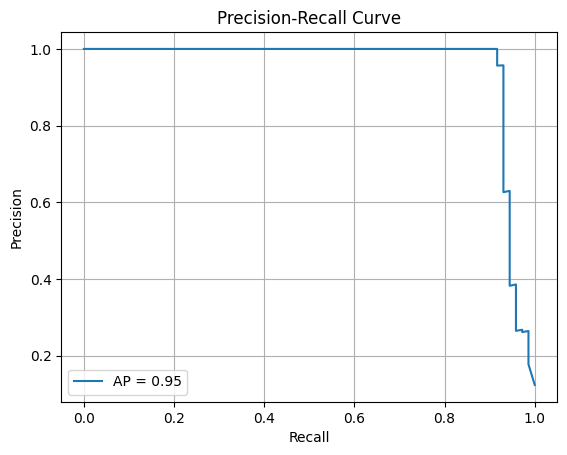

In [68]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(Y_test, risk_scores[:, 1])
average_precision = average_precision_score(Y_test, risk_scores[:, 1])

print(f"Average Precision Score: {average_precision}")

plt.figure()
plt.plot(recall, precision, label=f"AP = {average_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

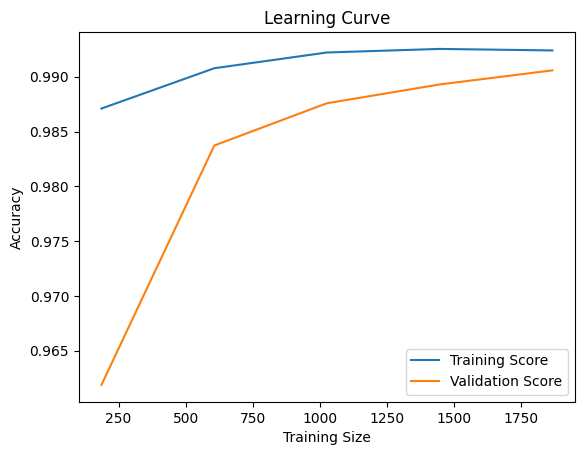

In [69]:
# learning curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    clf.best_estimator_, X_train, Y_train, cv=5, scoring='accuracy'
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Validation Score")
plt.legend()
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()

In [80]:
# !pip install shap

In [107]:
import shap
print("Computing shap values")
explainer=shap.TreeExplainer(clf.best_estimator_)
shap_values = explainer(X_train)

Computing shap values


In [123]:
feature_names = feature_set + ["n_age", "n_self_identified_sex_Female","n_self_identified_sex_Male"]
trained_weights = clf.best_estimator_.feature_importances_
feature_weight_df = pd.DataFrame(list(zip(feature_names, np.transpose(trained_weights)))).sort_values([1], ascending=False)
feature_weight_df.columns = ['feature', 'weight']


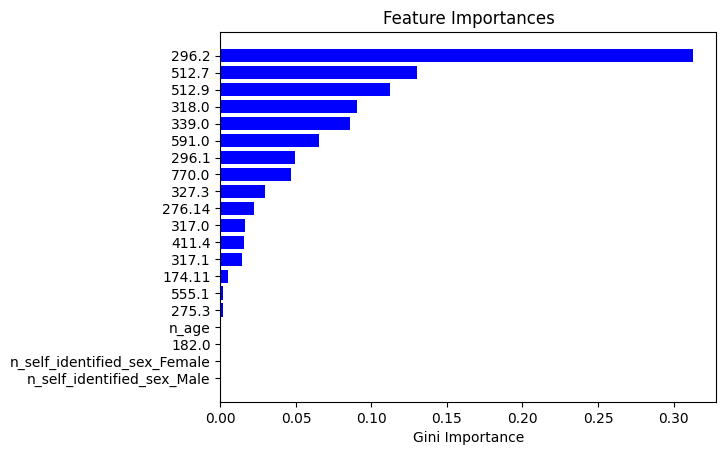

In [129]:
feature_names = feature_set + ["n_age", "n_self_identified_sex_Female","n_self_identified_sex_Male"]
importances = clf.best_estimator_.feature_importances_
# feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
# print(feature_imp_df)
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Gini Importance')
plt.savefig("FeatureImportance.png")

In [124]:
feature_weight_df

,feature,weight
1,296.2,0.312815
12,512.7,0.130224
9,512.9,0.112537
6,318.0,0.090218
16,339.0,0.085931
3,591.0,0.065412
0,296.1,0.049059
2,770.0,0.046515
8,327.3,0.029302
7,276.14,0.022168


<Axes: >

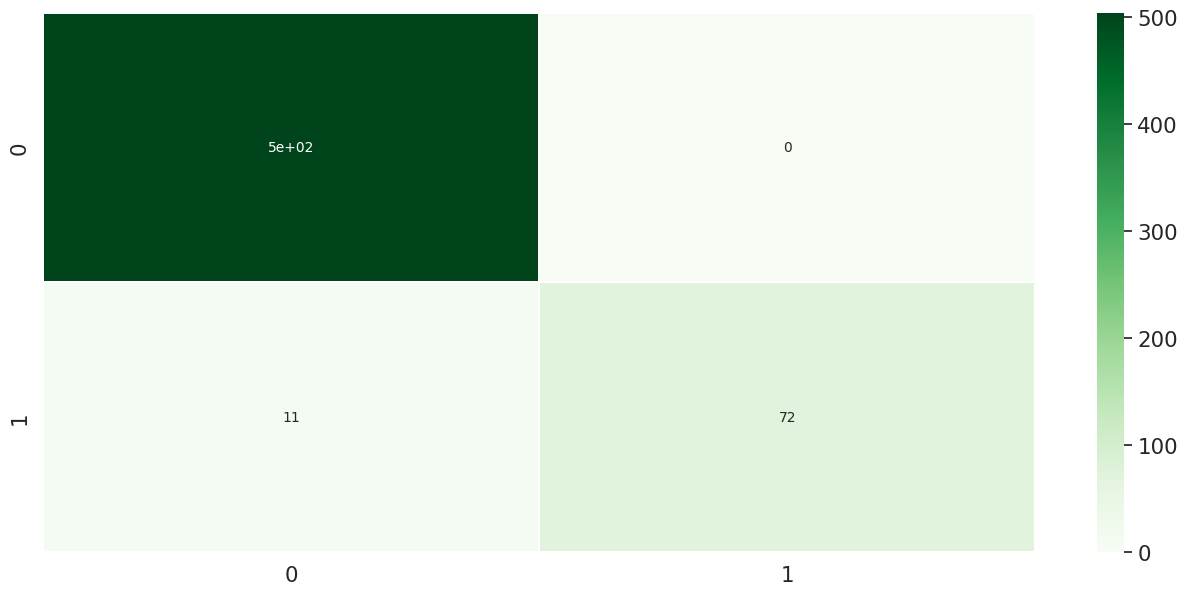

In [97]:
matrix = confusion_matrix(Y_test, y_pred)
# matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# # Add labels to the plot
# class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
#                'Cottonwood/Willow', 'Aspen', 'Douglas-fir',    
#                'Krummholz']
# tick_marks = np.arange(len(class_names))
# tick_marks2 = tick_marks + 0.5
# plt.xticks(tick_marks, class_names, rotation=25)
# plt.yticks(tick_marks2, class_names, rotation=0)
# plt.xlabel('Predicted label')
# plt.ylabel('True label')
# plt.title('Confusion Matrix for Random Forest Model')
# plt.show()

In [ ]:
risk_scores =clf.predict_proba(X_test_clean)

In [91]:
probabilities = clf.predict_proba(X_test)

In [82]:
probabilities

array([[0.56, 0.44],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.02, 0.98]])

In [105]:
feature_names = feature_set + ["n_age", "n_self_identified_sex_Female","n_self_identified_sex_Male"]
importances = clf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'

In [95]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, y_pred)

array([[504,   0],
       [ 11,  72]])